In [1]:
import pandas as pd
import psycopg2
from psycopg2 import sql
import xlrd
import config
from tables.static_data import query
from tables.market_history import query as market_history_query
from psycopg2 import sql
import config
import os
from networkx.readwrite import json_graph
import networkx as nx
import numpy as np

In [2]:
# load trimmed graph
graph = nx.read_gml('galaxy_region_graph_coords_subgraph_typeid_262.gml')

In [3]:
for node in graph.nodes(data=True):
    print(node)


('Metropolis', {'region_ID': 10000042, 'idx': 0})
('TheForge', {'region_ID': 10000002, 'idx': 1})
('SinqLaison', {'region_ID': 10000032, 'idx': 2})
('Domain', {'region_ID': 10000043, 'idx': 3})
('Tash-Murkon', {'region_ID': 10000020, 'idx': 4})
('Lonetrek', {'region_ID': 10000016, 'idx': 5})
('Heimatar', {'region_ID': 10000030, 'idx': 6})
('TheCitadel', {'region_ID': 10000033, 'idx': 7})
('Devoid', {'region_ID': 10000036, 'idx': 8})


In [4]:
timeseries_dict = {}

for node, attrs in graph.nodes(data=True):
    region_id = attrs.get('region_ID', 'No region_id assigned')
    print(f"Node {node} has region_ID: {region_id}.")
    # check if "Graphs/datasets/price_data_{node}.csv" exists:
    if os.path.exists(f"Graphs/datasets/Multifrequency_L/timeseries/price_data_{node}.csv"):
        print(f"Price data for node {node} exists, loading data...")
        timeseries_dict[node] = pd.read_csv(f"Graphs/datasets/Multifrequency_L/timeseries/price_data_{node}.csv")
    else:
        print(f"Price data for node {node} does not exist.")

        

    print(f"Price data for node {node} loaded from Graphs/datasets/price_data_{node}.")

Node Metropolis has region_ID: 10000042.
Price data for node Metropolis exists, loading data...
Price data for node Metropolis loaded from Graphs/datasets/price_data_Metropolis.
Node TheForge has region_ID: 10000002.
Price data for node TheForge exists, loading data...
Price data for node TheForge loaded from Graphs/datasets/price_data_TheForge.
Node SinqLaison has region_ID: 10000032.
Price data for node SinqLaison exists, loading data...
Price data for node SinqLaison loaded from Graphs/datasets/price_data_SinqLaison.
Node Domain has region_ID: 10000043.
Price data for node Domain exists, loading data...
Price data for node Domain loaded from Graphs/datasets/price_data_Domain.
Node Tash-Murkon has region_ID: 10000020.
Price data for node Tash-Murkon exists, loading data...
Price data for node Tash-Murkon loaded from Graphs/datasets/price_data_Tash-Murkon.
Node Lonetrek has region_ID: 10000016.
Price data for node Lonetrek exists, loading data...
Price data for node Lonetrek loaded fr

In [5]:
for node, data in timeseries_dict.items():
    print(f"Timeseries data for node {node} has shape: {data.shape}.")

Timeseries data for node Metropolis has shape: (1134, 8).
Timeseries data for node TheForge has shape: (1448, 8).
Timeseries data for node SinqLaison has shape: (1438, 8).
Timeseries data for node Domain has shape: (1448, 8).
Timeseries data for node Tash-Murkon has shape: (753, 8).
Timeseries data for node Lonetrek has shape: (842, 8).
Timeseries data for node Heimatar has shape: (1226, 8).
Timeseries data for node TheCitadel has shape: (385, 8).
Timeseries data for node Devoid has shape: (97, 8).


In [119]:
import pandas as pd

resampled_timeseries_list = []
node_dict = {}
i = 0
for node, dataframe in timeseries_dict.items():
    node_dict[node] = {}
    # Convert 'date' column to datetime type and sort by this date
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe = dataframe.sort_values(by='date')

    # Set the 'date' column as the index
    dataframe.set_index('date', inplace=True)

    # Resample the DataFrame to fill missing dates, assuming daily frequency
    resampled_df = dataframe.resample('D').asfreq()

    # Find where there are missing data points in the DataFrame
    missing_dates = resampled_df[resampled_df.isna().any(axis=1)].index
    number_of_missing_dates = len(missing_dates)

    resampled_df = resampled_df.interpolate(method='linear', axis=0).ffill().bfill()
    resampled_df = resampled_df.drop(columns=['region_id', 'type_id'])
    resampled_list = resampled_df.values.T.tolist()
    print(resampled_df.head())
    node_dict[node]['timeseries'] = resampled_df
    node_dict[node]['idx'] = graph.nodes[node]['idx']
    resampled_timeseries_list.append(resampled_list)
    i += i
    
    
    # Print the number of missing dates and the actual dates
    print(f"Node {node} has {number_of_missing_dates} missing dates.")
    print("Missing dates:", missing_dates.strftime('%Y-%m-%d').tolist())
    print(f"Node {node} has {len(resampled_df)} dates after resampling.")

             average   highest  lowest  volume  order_count
date                                                       
2020-01-01  577889.0  650000.0  1000.0    18.0          2.0
2020-01-02  289444.5  325500.0  1000.0    12.5          1.5
2020-01-03    1000.0    1000.0  1000.0     7.0          1.0
2020-01-04    1000.0    1000.0  1000.0   276.0          3.0
2020-01-05  491769.0  639000.0  1000.0    13.0          2.0
Node Metropolis has 317 missing dates.
Missing dates: ['2020-01-02', '2020-01-09', '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-28', '2020-01-30', '2020-02-06', '2020-02-11', '2020-02-27', '2020-03-07', '2020-03-13', '2020-03-16', '2020-03-17', '2020-03-19', '2020-03-26', '2020-04-07', '2020-04-15', '2020-04-23', '2020-04-24', '2020-04-27', '2020-04-30', '2020-05-04', '2020-05-05', '2020-05-08', '2020-05-10', '2020-05-21', '2020-06-05', '2020-06-14', '2020-06-19', '2020-06-25', '2020-06-26', '2020-06-29', '2020-07-12', '2020-07-13', '2020-07-20', '2020-07-24', '2020-0

In [120]:
import pandas as pd


# Process each dataframe in the dictionary
for key, elements in node_dict.items():
    
    df = elements['timeseries']
    # Drop unwanted columns
    # df.drop(columns=['region_id', 'type_id'], inplace=True)
    
    # Calculate 7-day and 30-day moving averages for each column
    for column in df.columns:
        df[f'{column}_7d_avg'] = df[column].rolling(window=7, min_periods=1).mean()
        df[f'{column}_30d_avg'] = df[column].rolling(window=30, min_periods=1).mean()
        
    for column in df.columns:
        # Calculate the percentile for each element in the column based on a 7-day rolling window
        df[f'{column}_7d_percentile'] = df[column].rolling(window=7, min_periods=1).apply(
            lambda x: pd.Series(x).rank(pct=True)[-1], raw=False
        )
        df[f'{column}_30d_percentile'] = df[column].rolling(window=30, min_periods=1).apply(
            lambda x: pd.Series(x).rank(pct=True)[-1], raw=False
        )



In [124]:
node_dict['TheForge']['timeseries'].columns

Index(['average', 'highest', 'lowest', 'volume', 'order_count',
       'average_7d_avg', 'average_30d_avg', 'highest_7d_avg',
       'highest_30d_avg', 'lowest_7d_avg', 'lowest_30d_avg', 'volume_7d_avg',
       'volume_30d_avg', 'order_count_7d_avg', 'order_count_30d_avg',
       'average_7d_percentile', 'average_30d_percentile',
       'highest_7d_percentile', 'highest_30d_percentile',
       'lowest_7d_percentile', 'lowest_30d_percentile', 'volume_7d_percentile',
       'volume_30d_percentile', 'order_count_7d_percentile',
       'order_count_30d_percentile', 'average_7d_avg_7d_percentile',
       'average_7d_avg_30d_percentile', 'average_30d_avg_7d_percentile',
       'average_30d_avg_30d_percentile', 'highest_7d_avg_7d_percentile',
       'highest_7d_avg_30d_percentile', 'highest_30d_avg_7d_percentile',
       'highest_30d_avg_30d_percentile', 'lowest_7d_avg_7d_percentile',
       'lowest_7d_avg_30d_percentile', 'lowest_30d_avg_7d_percentile',
       'lowest_30d_avg_30d_percentile'

<Axes: xlabel='date'>

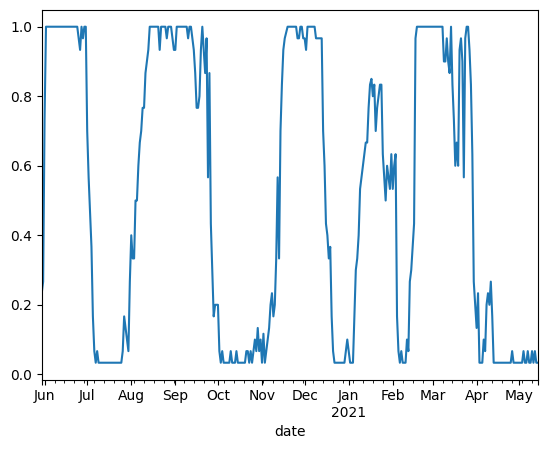

In [137]:
node_dict['TheForge']['timeseries']['average_30d_avg_30d_percentile'].iloc[150:500].plot()

<Axes: xlabel='date'>

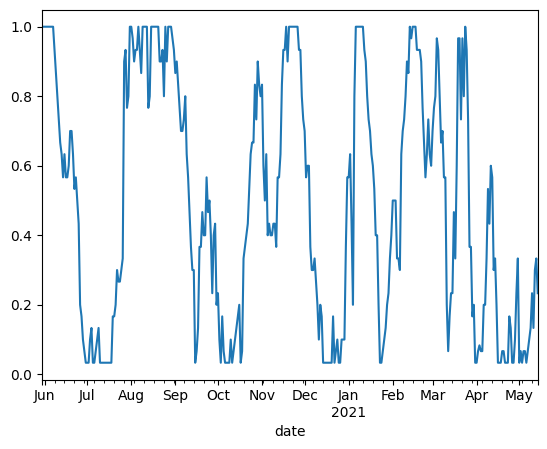

In [146]:
node_dict['TheForge']['timeseries']['average_7d_avg_30d_percentile'].iloc[150:500].plot()

<Axes: xlabel='date'>

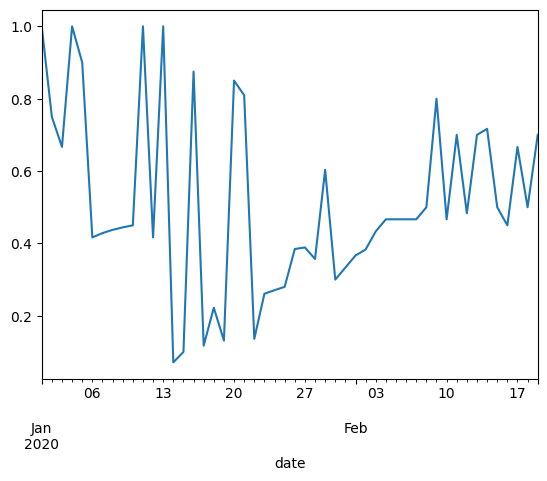

In [160]:
node_dict['TheForge']['timeseries']['average_30d_percentile'].iloc[0:50].plot()

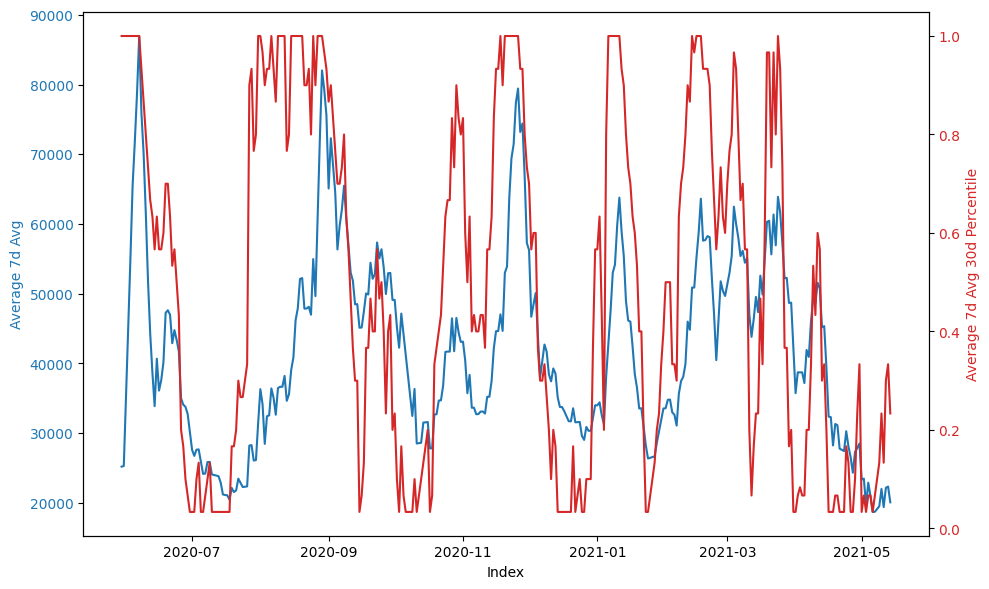

In [149]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Average 7d Avg', color=color)
ax1.plot(node_dict['TheForge']['timeseries']['average_7d_avg'].iloc[150:500], label='Average 7d Avg', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Average 7d Avg 30d Percentile', color=color)  # we already handled the x-label with ax1
ax2.plot(node_dict['TheForge']['timeseries']['average_7d_avg_30d_percentile'].iloc[150:500], label='Average 7d Avg 30d Percentile', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

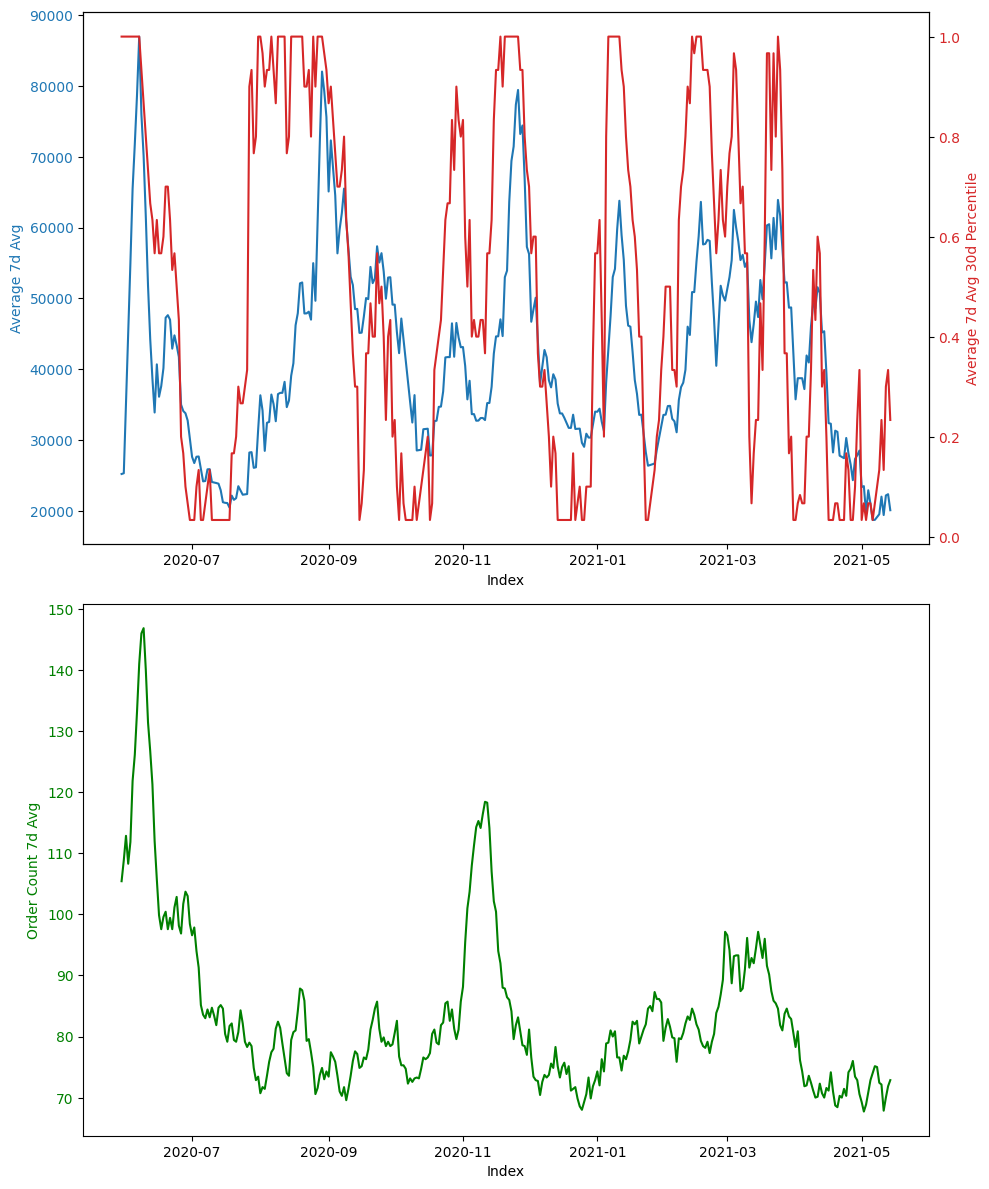

In [151]:
import matplotlib.pyplot as plt

# Create a figure and two subplots (ax1 and ax3) arranged vertically
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 12))

# First subplot with dual y-axes for 'average_7d_avg' and 'average_7d_avg_30d_percentile'
color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Average 7d Avg', color=color)
ax1.plot(node_dict['TheForge']['timeseries']['average_7d_avg'].iloc[150:500], label='Average 7d Avg', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for ax1
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average 7d Avg 30d Percentile', color=color)
ax2.plot(node_dict['TheForge']['timeseries']['average_7d_avg_30d_percentile'].iloc[150:500], label='Average 7d Avg 30d Percentile', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Second subplot for 'order_count_7d_avg'
ax3.plot(node_dict['TheForge']['timeseries']['order_count_7d_avg'].iloc[150:500], label='Order Count 7d Avg', color='green')
ax3.set_xlabel('Index')
ax3.set_ylabel('Order Count 7d Avg', color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.tight_layout()  # Adjust the layout
plt.show()

<Axes: xlabel='date'>

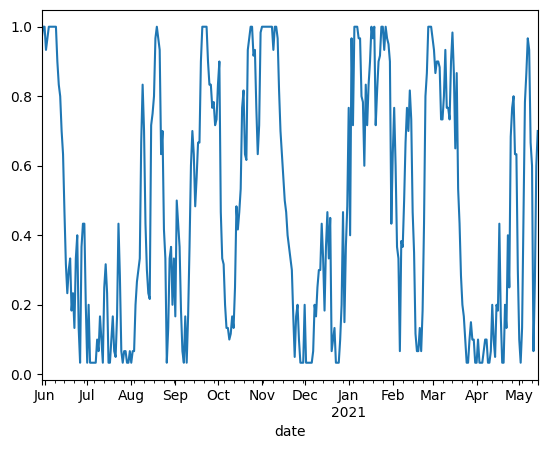

In [142]:
node_dict['TheForge']['timeseries']['order_count_7d_avg_30d_percentile'].iloc[150:500].plot()

<Axes: xlabel='date'>

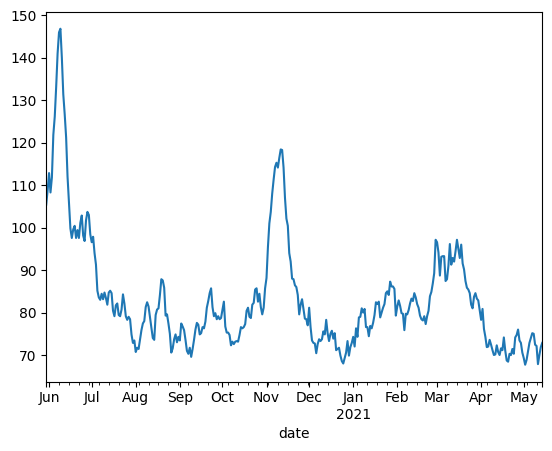

In [143]:
node_dict['TheForge']['timeseries']['order_count_7d_avg'].iloc[150:500].plot()

<Axes: xlabel='date'>

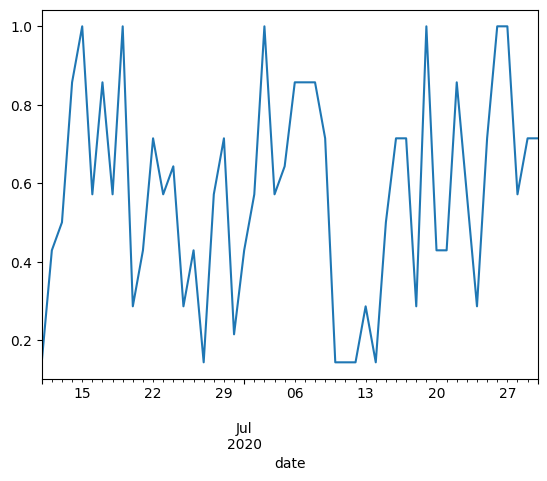

In [179]:
node_dict['TheForge']['timeseries']['average_7d_percentile'].iloc[150:200].plot()

In [162]:
starter_dict = {}

for key, elements in node_dict.items():
    timeseries = elements['timeseries']['average_30d_percentile']
    idx = elements['idx']
    starter_dict[key] = {}
    starter_dict[key]['average_30d_percentile'] = timeseries
    starter_dict[key]['idx'] = idx


In [168]:
start_dates = []
end_dates = []
for key, elements in node_dict.items():
    start_date = node_dict[key]['timeseries'].index[0]
    start_dates.append(start_date)
    end_date = node_dict[key]['timeseries'].index[-1]
    end_dates.append(end_date)

In [169]:
start_dates

[Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-02 00:00:00', freq='D'),
 Timestamp('2020-01-13 00:00:00', freq='D')]

In [170]:
end_dates

[Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-19 00:00:00', freq='D'),
 Timestamp('2023-12-17 00:00:00', freq='D'),
 Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-21 00:00:00', freq='D'),
 Timestamp('2023-12-16 00:00:00', freq='D')]

### Make sure dates line up

In [171]:
# Step 1: Determine the maximum start date and minimum end date
start_dates = []
end_dates = []

for elements in node_dict.values():
    dates = elements['timeseries'].index
    start_dates.append(dates.min())
    end_dates.append(dates.max())

latest_start_date = max(start_dates)
earliest_end_date = min(end_dates)

# Step 2: Prune each DataFrame to match the determined date range
for key, elements in node_dict.items():
    df = elements['timeseries']
    # Trim the DataFrame to the common date range
    trimmed_df = df[(df.index >= latest_start_date) & (df.index <= earliest_end_date)]
    node_dict[key]['timeseries'] = trimmed_df

# Check the output
for key, elements in node_dict.items():
    print(f"Node: {key}, Data: \n{elements['timeseries']}\n")

Node: Metropolis, Data: 
             average    highest     lowest  volume  order_count  \
date                                                              
2020-01-13  567334.0  638000.00    2009.00   18.00         4.00   
2020-01-14    1000.0    1000.00    1000.00    3.00         1.00   
2020-01-15    2009.0    2009.00    2009.00    1.00         1.00   
2020-01-16  160215.0  160231.75  160206.75    2.25         1.25   
2020-01-17  318421.0  318454.50  318404.50    3.50         1.50   
...              ...        ...        ...     ...          ...   
2023-12-12    1116.0    1116.00    1116.00    4.00         2.00   
2023-12-13  286275.0  339000.00   20650.00    6.00         3.00   
2023-12-14  340000.0  340000.00  340000.00    8.00         1.00   
2023-12-15  345000.0  345000.00  345000.00    4.00         2.00   
2023-12-16   21122.0   21200.00   21100.00   10.00         5.00   

            average_7d_avg  average_30d_avg  highest_7d_avg  highest_30d_avg  \
date                   

In [172]:
start_dates = []
end_dates = []
for key, elements in node_dict.items():
    start_date = node_dict[key]['timeseries'].index[0]
    start_dates.append(start_date)
    end_date = node_dict[key]['timeseries'].index[-1]
    end_dates.append(end_date)

In [175]:
for key, elements in node_dict.items():
    start_date = node_dict[key]['timeseries'].index[0]
    end_date = node_dict[key]['timeseries'].index[-1]
    length = len(node_dict[key]['timeseries'])
    print(f"Node: {key}, Length: {length}, Start Date: {start_dates}, End Date: {end_dates}")

Node: Metropolis, Length: 1434, Start Date: [Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D')], End Date: [Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D'), Timestamp('2023-12-16 00:00:00', freq='D')]
Node: TheForge, Length: 1434, Start Date: [Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-13 00:00:00', freq='D'), Timestamp('2020-01-1

In [31]:
node_indices_dict = {node_name: node['idx'] for node_name, node in node_dict.items()}

In [62]:
node_indices_dict

{'Metropolis': 0,
 'TheForge': 1,
 'SinqLaison': 2,
 'Domain': 3,
 'Tash-Murkon': 4,
 'Lonetrek': 5,
 'Heimatar': 6,
 'TheCitadel': 7,
 'Devoid': 8}

In [63]:
edge_list = []

for edge in graph.edges(data=True):
    print(edge)
    source_name = edge[0]
    destination_name = edge[1]
    source_idx = node_indices_dict[source_name]
    destination_idx = node_indices_dict[destination_name]
    edge_array = [source_idx, destination_idx]
    edge_list.append(edge_array)

('Metropolis', 'TheForge', {'weight': 1})
('Metropolis', 'SinqLaison', {'weight': 1})
('Metropolis', 'Heimatar', {'weight': 1})
('TheForge', 'Lonetrek', {'weight': 1})
('TheForge', 'SinqLaison', {'weight': 1})
('SinqLaison', 'Domain', {'weight': 1})
('SinqLaison', 'TheCitadel', {'weight': 1})
('SinqLaison', 'Heimatar', {'weight': 1})
('Domain', 'Tash-Murkon', {'weight': 1})
('Domain', 'Devoid', {'weight': 1})
('Lonetrek', 'TheCitadel', {'weight': 1})
('Heimatar', 'Devoid', {'weight': 1})


In [163]:
edge_list

[[0, 1],
 [0, 2],
 [0, 6],
 [1, 5],
 [1, 2],
 [2, 3],
 [2, 7],
 [2, 6],
 [3, 4],
 [3, 8],
 [5, 7],
 [6, 8]]

In [180]:
# Converting 'timeseries' DataFrame of each node to a list of lists
list_of_lists = [node['timeseries']['average_7d_percentile'].values.tolist() for node in node_dict.values()]

print(list_of_lists)


[[0.5714285714285714, 0.14285714285714285, 0.2857142857142857, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 1.0, 0.8571428571428571, 0.14285714285714285, 0.2857142857142857, 0.35714285714285715, 0.5714285714285714, 0.5714285714285714, 0.21428571428571427, 0.7142857142857143, 0.5714285714285714, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 1.0, 1.0, 0.14285714285714285, 1.0, 0.7142857142857143, 0.42857142857142855, 0.2857142857142857, 0.8571428571428571, 0.35714285714285715, 0.2857142857142857, 0.5714285714285714, 0.8571428571428571, 0.14285714285714285, 0.8571428571428571, 0.7142857142857143, 0.35714285714285715, 0.7142857142857143, 0.35714285714285715, 0.42857142857142855, 1.0, 0.35714285714285715, 0.42857142857142855, 0.7142857142857143, 0.8571428571428571, 1.0, 0.2857142857142857, 0.35714285714285715, 0.35714285714285715, 0.7142857142857143, 0.14285714285714285, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.5714285714285714, 0.142857142

In [181]:
json_dict = {
   'edges': edge_list,
    'node_ids': node_indices_dict,
    'FX': list_of_lists
}

In [182]:
json_dict

{'edges': [[0, 1],
  [0, 2],
  [0, 6],
  [1, 5],
  [1, 2],
  [2, 3],
  [2, 7],
  [2, 6],
  [3, 4],
  [3, 8],
  [5, 7],
  [6, 8]],
 'node_ids': {'Metropolis': 0,
  'TheForge': 1,
  'SinqLaison': 2,
  'Domain': 3,
  'Tash-Murkon': 4,
  'Lonetrek': 5,
  'Heimatar': 6,
  'TheCitadel': 7,
  'Devoid': 8},
 'FX': [[0.5714285714285714,
   0.14285714285714285,
   0.2857142857142857,
   0.5714285714285714,
   0.7142857142857143,
   0.8571428571428571,
   1.0,
   0.8571428571428571,
   0.14285714285714285,
   0.2857142857142857,
   0.35714285714285715,
   0.5714285714285714,
   0.5714285714285714,
   0.21428571428571427,
   0.7142857142857143,
   0.5714285714285714,
   0.2857142857142857,
   0.42857142857142855,
   0.5714285714285714,
   1.0,
   1.0,
   0.14285714285714285,
   1.0,
   0.7142857142857143,
   0.42857142857142855,
   0.2857142857142857,
   0.8571428571428571,
   0.35714285714285715,
   0.2857142857142857,
   0.5714285714285714,
   0.8571428571428571,
   0.14285714285714285,
   0.857

In [183]:
# save json_dict as json file
import json
filename = 'eve_regionhubs_262_multifrequency_L_averag_7d_percentilee.json'

# Use the json module to save the dictionary to a file
with open(filename, 'w') as file:
    json.dump(json_dict, file)

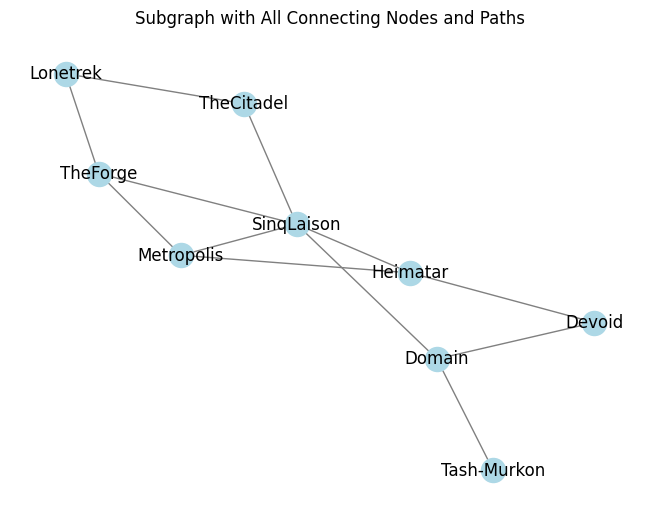

In [32]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph)  # Use spring layout for a nice layout
nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Subgraph with All Connecting Nodes and Paths')
plt.show()


In [24]:
# Print edges with more detail
for u, v, data in graph.edges(data=True):
    weight = data.get('weight', 1)  # Default weight is 1 if not specified
    print(f"Edge from {u} to {v} with weight {weight}")

In [20]:
# Creating a list of connections using idx values
connections_list = [(graph.nodes[edge[0]]['idx'], graph.nodes[edge[1]]['idx']) for edge in graph.edges()]

connections_list


[]

In [22]:
for edge in graph.edges():
    print(edge)
    print(graph.nodes[edge[0]]['idx'], graph.nodes[edge[1]]['idx'])

In [12]:
import networkx as nx
import pandas as pd
import json

# Assuming 'graph' is your NetworkX graph object
# Assuming 'resampled_timeseries_dict' contains the node data as pandas DataFrames

def create_graph_json(graph, timeseries_dict):
    edges = []
    node_names = []
    node_timeseries = []

    for node in graph.nodes:
        # Append node names
        node_names.append(node)
        
        # Append edges for each node
        connected_nodes = nx.node_connected_component(graph, node)  # This gets all connected nodes to 'node'
        
        for node in connected_nodes:
            
        
        
        edges.append(connected_nodes)
        print("Connected nodes for node", node, "are:", connected_nodes)
        print(connected_nodes)
        # Convert DataFrame to a list of lists (rows) for JSON compatibility
        if node in timeseries_dict:
            # Converting DataFrame to list of lists for each column
            df_as_list = timeseries_dict[node].fillna(0).values.tolist()  # Filling NaNs for safety
            node_timeseries.append(df_as_list)
        else:
            node_timeseries.append([])  # Empty list if no timeseries data

    # Construct the JSON-compatible dictionary
    graph_json = {
        "edges": edges,
        "node_names": node_names,
        "node_timeseries": node_timeseries
    }

    # # Convert the dictionary to a JSON string
    # json_output = json.dumps(graph_json, indent=4)
    return graph_json

# Example usage
graph_json = create_graph_json(graph, resampled_timeseries_dict)
# print(graph_json)


Connected nodes for node Metropolis are: {'Metropolis'}
{'Metropolis'}
Connected nodes for node Tash-Murkon are: {'Tash-Murkon'}
{'Tash-Murkon'}
Connected nodes for node TheForge are: {'TheForge'}
{'TheForge'}
Connected nodes for node Heimatar are: {'Heimatar'}
{'Heimatar'}
Connected nodes for node Lonetrek are: {'Lonetrek'}
{'Lonetrek'}
Connected nodes for node SinqLaison are: {'SinqLaison'}
{'SinqLaison'}
Connected nodes for node Domain are: {'Domain'}
{'Domain'}


In [13]:
print(graph_json)

{'edges': [{'Metropolis'}, {'Tash-Murkon'}, {'TheForge'}, {'Heimatar'}, {'Lonetrek'}, {'SinqLaison'}, {'Domain'}], 'node_names': ['Metropolis', 'Tash-Murkon', 'TheForge', 'Heimatar', 'Lonetrek', 'SinqLaison', 'Domain'], 'node_timeseries': [[[10000042.0, 262.0, 577889.0, 650000.0, 1000.0, 18.0, 2.0], [10000042.0, 262.0, 289444.5, 325500.0, 1000.0, 12.5, 1.5], [10000042.0, 262.0, 1000.0, 1000.0, 1000.0, 7.0, 1.0], [10000042.0, 262.0, 1000.0, 1000.0, 1000.0, 276.0, 3.0], [10000042.0, 262.0, 491769.0, 639000.0, 1000.0, 13.0, 2.0], [10000042.0, 262.0, 2009.0, 2009.0, 2009.0, 1.0, 1.0], [10000042.0, 262.0, 147347.0, 147347.0, 147347.0, 1.0, 1.0], [10000042.0, 262.0, 587818.0, 638000.0, 500000.0, 22.0, 7.0], [10000042.0, 262.0, 612909.0, 638000.0, 569000.0, 11.5, 4.0], [10000042.0, 262.0, 638000.0, 638000.0, 638000.0, 1.0, 1.0], [10000042.0, 262.0, 510802.0, 638000.0, 2009.0, 10.0, 2.0], [10000042.0, 262.0, 150000.0, 150000.0, 150000.0, 114.0, 5.0], [10000042.0, 262.0, 567334.0, 638000.0, 200